In [1]:
from collections.abc import Iterable
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.ops import shared_paths

import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns


%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
path = r"D:\tencent files\chrome Download\Research\LCA\LCA Coal_fired power plant phaseout\data"
map_path = r"D:\tencent files\chrome Download\QGIS 3.12\中国基础数据\中国行政区.shp"

trans_2010 = r"coal_transport2010"
trans_2014 = r"coal_transport2014"

geo_data_file = r"Distance_matrix"

transport_matrix_2010 = r"coal_trasport2010.xlsx"
transport_matrix_2014 = r"coal_trasport2014.xlsx"

power_plants_orginal_2010 = r"coal_elec_gen2010_SD.xlsx"
power_plants_orginal_2014 = r"coal_elec_gen2014_SD.xlsx"
mines = "node_mine_pair.xlsx"
power_plants = "node_power_pair.xlsx"
file = r"Results.xlsx"

power_plant_points_2010 = os.path.join(path, trans_2010, power_plants_orginal_2010)
transport_route_path_2010 = os.path.join(path, trans_2010, geo_data_file)
transport_quantity_path_2010 = os.path.join(path, trans_2010, transport_matrix_2010)

power_plant_points_2014 = os.path.join(path, trans_2014, power_plants_orginal_2014)
transport_route_path_2014 = os.path.join(path, trans_2014, geo_data_file)
transport_quantity_path_2014 = os.path.join(path, trans_2014, transport_matrix_2014)

<IPython.core.display.Javascript object>

In [157]:
os.chdir(os.path.join(path, trans_2010))

with open("transport_route_gdf.pickle", "rb") as file:
    transport_gdf_2010 = pickle.load(file)

with open("retire_transport_path.pickle", "rb") as file:
    retire_transport_path = pickle.load(file)

with open("persist_transport_path_2010.pickle", "rb") as file:
    persist_transport_path_2010 = pickle.load(file)

with open("persist_transport_path_2014.pickle", "rb") as file:
    persist_transport_path_2014 = pickle.load(file)

with open("newly_built_transport_path.pickle", "rb") as file:
    newly_built_transport_path = pickle.load(file)

os.chdir(os.path.join(path, trans_2014))

with open("transport_route_gdf.pickle", "rb") as file:
    transport_gdf_2014 = pickle.load(file)

<IPython.core.display.Javascript object>

In [4]:
def CHN_map(map_path):
    CHN_adm = gpd.read_file(map_path)
    CHN_adm.to_crs("epsg:4326")
    return CHN_adm

<IPython.core.display.Javascript object>

In [5]:
def power_plant_data(transport_gdf1):
    pp_ls = gpd.GeoDataFrame(
        [
            Point(list(transport_gdf1.geometry.iloc[i].coords)[-1])
            for i in range(len(transport_gdf1.geometry))
        ],
        columns=["geometry"],
    ).set_index(transport_gdf1.index)

    power_plant = gpd.GeoDataFrame(  # 2010年电厂位置
        pd.concat([pp_ls, transport_gdf1[0]], axis=1)
    )
    power_plant.columns = ["geometry", "coal_quantity"]

    return power_plant

<IPython.core.display.Javascript object>

In [6]:
def map_draw(transport_gdf, power_plant_path, color_dict, map_path=map_path):
    """
    Draw a graph contains all the power plants and their coal transportation routes
    """

    fig, ax = plt.subplots(figsize=(16, 16), edgecolor="black")
    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(3)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.xlim((111, 124))
    plt.ylim((33, 41))

    CHN_adm = CHN_map(map_path)
    CHN_adm.plot(
        ax=ax, color=(0.95, 0.95, 0.95), edgecolor=(0.90, 0.92, 0.91), linewidth=2.5
    )

    max_ = transport_gdf.iloc[:, -1].max()
    min_ = transport_gdf.iloc[:, -1].min()
    mean_ = transport_gdf.iloc[:, -1].mean()

    persist_gdf_2010 = power_plant_data(persist_transport_path_2010)
    persist_gdf_2014 = power_plant_data(persist_transport_path_2014)
    retire_gdf = power_plant_data(retire_transport_path)
    newly_built_gdf = power_plant_data(newly_built_transport_path)

    if transport_gdf is transport_gdf_2010:
        persist_transport_path_2010.plot(
            column=np.log10(persist_transport_path_2010.iloc[:, -1]),
            ax=ax,
            cmap="YlGnBu",
            linewidth=50
            * (persist_transport_path_2010.iloc[:, -1] - min_ + 50000)
            / (max_ - min_),
            legend=False,
            vmin=3.5,
            vmax=7,
        )
        retire_transport_path.plot(
            column=np.log10(retire_transport_path.iloc[:, -1]),
            ax=ax,
            cmap="YlGnBu",
            linewidth=50
            * (retire_transport_path.iloc[:, -1] - min_ + 50000)
            / (max_ - min_),
            legend=False,
            vmin=3.5,
            vmax=7,
        )

        persist_gdf_2010.plot(
            ax=ax,
            facecolors="none",
            edgecolors=color_dict["persist"],
            marker="o",
            linewidth=4,
            markersize=persist_gdf_2010["coal_quantity"] / 3000,
            alpha=0.7,
        )  # 画持续存在的电厂2010

        retire_gdf.plot(
            ax=ax,
            facecolors="None",
            edgecolors=color_dict["retire"],
            marker="o",
            linewidth=4,
            linestyle="solid",
            markersize=retire_gdf["coal_quantity"] / 3000,
        )  # 画退役电厂

    else:
        persist_transport_path_2014.plot(
            column=np.log10(persist_transport_path_2014.iloc[:, -1]),
            ax=ax,
            cmap="YlGnBu",
            linewidth=50
            * (persist_transport_path_2014.iloc[:, -1] - min_ + 50000)
            / (max_ - min_),
            legend=False,
            vmin=3.5,
            vmax=7,
        )
        newly_built_transport_path.plot(
            column=np.log10(newly_built_transport_path.iloc[:, -1]),
            ax=ax,
            cmap="YlGnBu",
            linewidth=50
            * (newly_built_transport_path.iloc[:, -1] - min_ + 50000)
            / (max_ - min_),
            legend=False,
            vmin=3.5,
            vmax=7,
        )

        persist_gdf_2014.plot(
            ax=ax,
            facecolors="none",
            edgecolors=color_dict["persist"],
            marker="o",
            linewidth=4,
            markersize=persist_gdf_2014["coal_quantity"] / 3000,
            alpha=0.7,
        )  # 画持续存在的电厂2014
        newly_built_gdf.geometry.plot(
            ax=ax,
            facecolors="None",
            edgecolors=color_dict["newly_built"],
            marker="o",
            linewidth=4,
            linestyle="solid",
            markersize=newly_built_gdf["coal_quantity"] / 3000,
        )  # 画新建电厂
    mine = gpd.GeoDataFrame(
        [
            Point(list(transport_gdf.geometry.iloc[i].coords)[0])
            for i in range(len(transport_gdf.geometry))
        ],
        columns=["geometry"],
    )
    mine_screened = []
    for point in mine.geometry:
        if not any(p.distance(point) <= 0.2 for p in mine_screened):
            mine_screened.append(point)

    mine_screened_gdf = gpd.GeoDataFrame(mine_screened, columns=["geometry"])
    mine_screened_gdf.plot(
        ax=ax,
        facecolors="none",
        edgecolors=color_dict["mine"],
        marker="^",
        linewidth=4,
        markersize=200,
        alpha=1,
    )

    return fig

<IPython.core.display.Javascript object>

In [170]:
def map_draw_simplified(
    transport_gdf, power_plant_path, color_dict, vmin, vmax, map_path=map_path
):
    """
    Draw a graph contains only retired and newly built power plants and their coal transportation routes
    """
    fig, ax = plt.subplots(figsize=(16, 16), edgecolor="black")
    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(3)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.xlim((111, 124))
    plt.ylim((33, 41))

    CHN_adm = CHN_map(map_path)
    CHN_adm.plot(
        ax=ax, color=(0.95, 0.95, 0.95), edgecolor=(0.90, 0.92, 0.91), linewidth=2.5
    )

    max_ = newly_built_transport_path.iloc[:, -1].max()
    min_ = newly_built_transport_path.iloc[:, -1].min()
    mean_ = newly_built_transport_path.iloc[:, -1].mean()

    if transport_gdf.equals(transport_gdf_2010):
        retire_transport_path.plot(
            column=np.log10(retire_transport_path.iloc[:, -1]),
            ax=ax,
            cmap="YlGnBu",
            linewidth=30 * (retire_transport_path.iloc[:, -1] - min_) / (max_ - min_),
            legend=False,
            vmin=vmin,
            vmax=vmax,
        )
        retire_gdf = power_plant_data(retire_transport_path)
        retire_gdf.plot(
            ax=ax,
            facecolors="None",
            edgecolors=color_dict["retire"],
            marker="o",
            linewidth=4,
            linestyle="solid",
            markersize=retire_gdf["coal_quantity"] / 3000,
        )  # 画退役电厂

        mine = gpd.GeoDataFrame(
            [
                Point(list(retire_transport_path.geometry.iloc[i].coords)[0])
                for i in range(len(retire_transport_path.geometry))
            ],
            columns=["geometry"],
        )

        mine_screened = []
        for point in mine.geometry:
            if not any(p.distance(point) <= 0.2 for p in mine_screened):
                mine_screened.append(point)

        mine_screened_gdf = gpd.GeoDataFrame(mine_screened, columns=["geometry"])
        mine_screened_gdf.plot(
            ax=ax,
            facecolors="none",
            edgecolors=color_dict["mine"],
            marker="^",
            linewidth=4,
            markersize=200,
            alpha=1,
        )
        return fig
    elif transport_gdf.equals(transport_gdf_2014):
        newly_built_transport_path.plot(
            column=np.log10(newly_built_transport_path.iloc[:, -1]),
            ax=ax,
            cmap="YlGnBu",
            linewidth=30
            * (newly_built_transport_path.iloc[:, -1] - min_)
            / (max_ - min_),
            legend=False,
            vmin=vmin,
            vmax=vmax,
        )
        newly_built_gdf = power_plant_data(newly_built_transport_path)
        newly_built_gdf.geometry.plot(
            ax=ax,
            facecolors="None",
            edgecolors=color_dict["newly_built"],
            marker="o",
            linewidth=4,
            linestyle="solid",
            markersize=newly_built_gdf["coal_quantity"] / 3000,
        )  # 画新建电厂
        mine = gpd.GeoDataFrame(
            [
                Point(list(newly_built_transport_path.geometry.iloc[i].coords)[0])
                for i in range(len(newly_built_transport_path.geometry))
            ],
            columns=["geometry"],
        )

        mine_screened = []
        for point in mine.geometry:
            if not any(p.distance(point) <= 0.2 for p in mine_screened):
                mine_screened.append(point)

        mine_screened_gdf = gpd.GeoDataFrame(mine_screened, columns=["geometry"])
        mine_screened_gdf.plot(
            ax=ax,
            facecolors="none",
            edgecolors=color_dict["mine"],
            marker="^",
            linewidth=4,
            markersize=200,
            alpha=1,
        )
        return fig

<IPython.core.display.Javascript object>

In [122]:
newly_built_gdf = power_plant_data(newly_built_transport_path)
newly_built_gdf

,geometry,coal_quantity
118701,POINT (116.06696 36.47882),31473.2190
118873,POINT (118.36353 35.11067),42677.0000
117183,POINT (116.04880 37.30978),54822.0000
116429,POINT (122.12754 37.51643),20757.2030
116462,POINT (122.12754 37.51643),8485.5944
...,...,...
117496,POINT (118.51368 36.99582),324659.0300
118000,POINT (118.51368 36.99582),90454.9750
118008,POINT (118.51368 36.99582),252355.8200
118701,POINT (118.51368 36.99582),173140.0800


<IPython.core.display.Javascript object>

In [163]:
max_ = newly_built_transport_path.iloc[:, -1].max()
min_ = newly_built_transport_path.iloc[:, -1].min()

<IPython.core.display.Javascript object>

In [164]:
max_, min_

(5004950.6, 2507.9098)

<IPython.core.display.Javascript object>

In [159]:
newly_built_transport_path.iloc[:, -1].sum()

44010449.419099994

<IPython.core.display.Javascript object>

In [167]:
np.power(10, 6)

1000000

<IPython.core.display.Javascript object>

In [166]:
retire_transport_path.iloc[:, -1].max()

2478767.0

<IPython.core.display.Javascript object>

In [58]:
newly_built_transport_path.iloc[:, -1].max()

3299233.0

<IPython.core.display.Javascript object>

In [8]:
def colorbar(transport_gdf):
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)

    norm = mpl.colors.Normalize(vmin=np.power(10,3.5), vmax=np.power(10,7))

    
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap="YlGnBu"),
        cax=ax,
        orientation="horizontal",
    )
    cbar.ax.tick_params(labelsize=12)


<IPython.core.display.Javascript object>

In [73]:
color_dict = {
    "persist": (0.96, 0.50, 0.09),  # orange
    "retire": (0.89, 0.10, 0.11),  # red
    "newly_built": (0.19, 0.64, 0.33),  # green
    "mine": (0.39, 0.39, 0.39),  # grey,
}

<IPython.core.display.Javascript object>

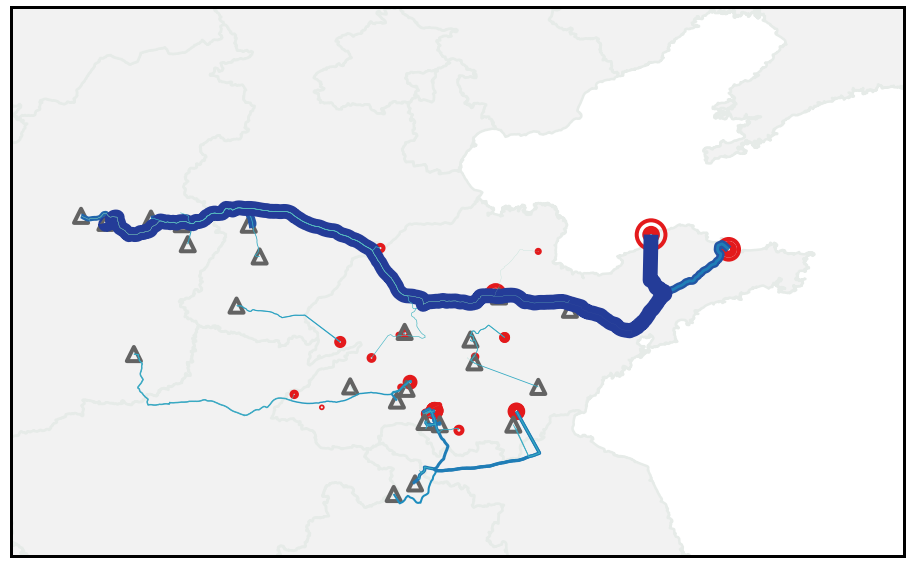

<IPython.core.display.Javascript object>

In [176]:
map_draw_simplified(
    transport_gdf_2010,
    power_plant_points_2010,
    color_dict=color_dict,
    vmin=3,
    vmax=7,
)

plt.savefig(
    r"D:\tencent files\chrome Download\Research\LCA\LCA Coal_fired power plant phaseout\Figures\transport_retire.png",
    dpi=600,
    bbox_inches="tight",
)

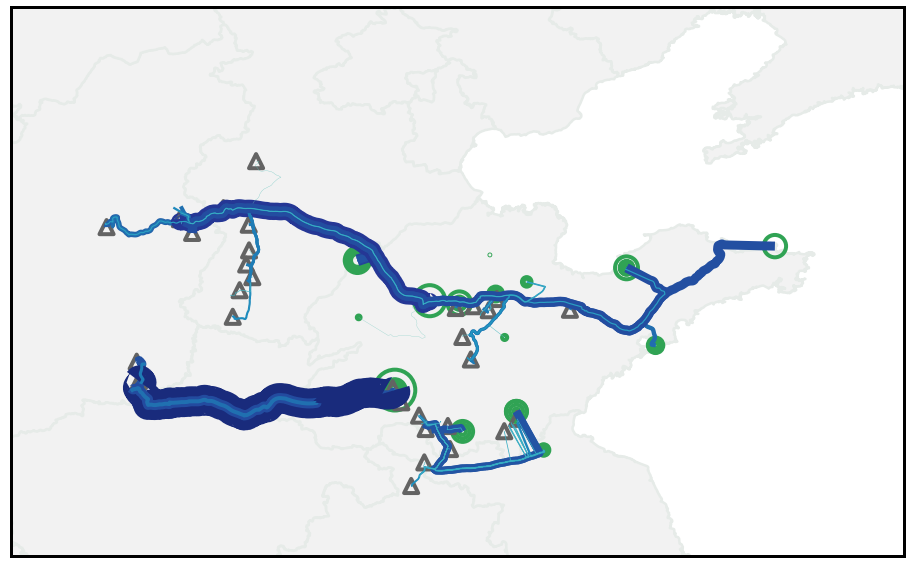

<IPython.core.display.Javascript object>

In [175]:
map_draw_simplified(
    transport_gdf_2014,
    power_plant_points_2014,
    color_dict=color_dict,
    vmin=3,
    vmax=7,
)

plt.savefig(
    r"D:\tencent files\chrome Download\Research\LCA\LCA Coal_fired power plant phaseout\Figures\transport_newly_built.png",
    dpi=600,
    bbox_inches="tight",
)

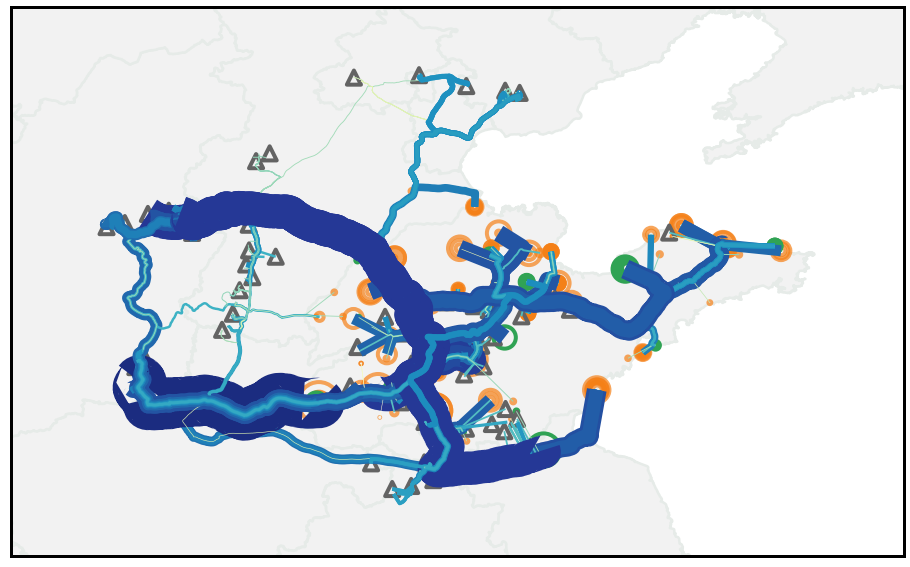

<IPython.core.display.Javascript object>

In [107]:
map_draw(transport_gdf_2014,power_plant_points_2014,color_dict=color_dict,)

plt.savefig(
    r"D:\tencent files\chrome Download\Research\LCA\LCA Coal_fired power plant phaseout\Figures\transport2014_re.png",
    dpi=600,
    bbox_inches="tight",
)


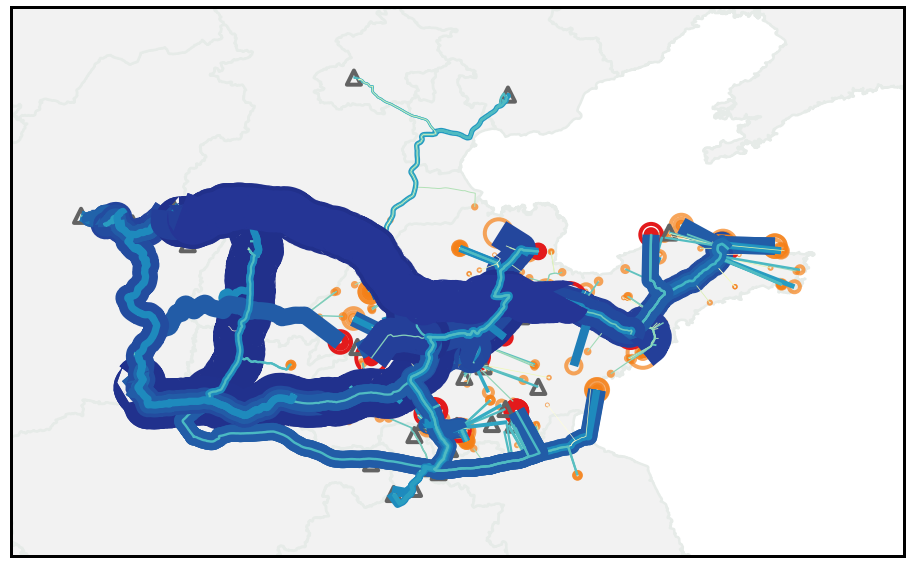

<IPython.core.display.Javascript object>

In [108]:
map_draw(transport_gdf_2010, power_plant_points_2010, color_dict=color_dict)

plt.savefig(
    r"D:\tencent files\chrome Download\Research\LCA\LCA Coal_fired power plant phaseout\Figures\transport2010_re.png",
    dpi=600,
    bbox_inches="tight",
)

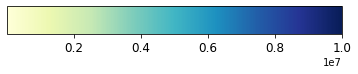

<IPython.core.display.Javascript object>

In [109]:
colorbar(transport_gdf_2010)

plt.savefig(
    r"D:\tencent files\chrome Download\Research\LCA\LCA Coal_fired power plant phaseout\Figures\transportcolor.png",
    dpi=600,
    bbox_inches="tight",
)

## Data manipulation

In [137]:
def read_gdf_file(transport_route_path, pp_type, i):
    """
    read geopandas dataframe files from a directory,
    each gdf file corresponds to a transport path of power plant to its mines
    the name of each gdf file is its id in graph algorithm
    transport_route_path is total route
    pp_type is the type of power plants, classified into "persist from 2010 to 2014", "retired in 2010-2014", "newly_builty in 2010-2014"
    """
    os.chdir(transport_route_path)

    with open(i, "rb") as file:
        transport_gdf = pickle.load(file)
    #     with open(gdf_file_list_screen[i], "rb") as file:
    #         transport_gdf = pickle.load(file)
    return transport_gdf

<IPython.core.display.Javascript object>

In [124]:
def read_distance_matrix(transport_quantity_path):
    trans_mat = pd.read_excel(transport_quantity_path, index_col=0).T.stack()
    return trans_mat

<IPython.core.display.Javascript object>

In [143]:
trans_mat = read_distance_matrix(transport_quantity_path_2010)
trans_mat.index

MultiIndex([(119318, 116330),
            (119318, 116331),
            (119318, 116332),
            (119318, 116333),
            (119318, 116335),
            (119318, 116337),
            (119318, 116339),
            (119318, 116341),
            (119318, 116342),
            (119318, 116344),
            ...
            (119677, 119303),
            (119677, 119305),
            (119677, 119307),
            (119677, 119308),
            (119677, 119310),
            (119677, 119311),
            (119677, 119312),
            (119677, 119313),
            (119677, 119315),
            (119677, 119317)],
           length=573780)

<IPython.core.display.Javascript object>

In [150]:
def gdf_concat(transport_route_path, transport_quantity_path, pp_type, i):
    """
    This function read transport route path and quantity and concatenate the two objects separately from two files

    gdf_concat(transport_route_path, transport_quantity_path, pp_type, i)
        return
        ------
        transport_df_route: DataFrame, concated transport route dataframe and quantity dataframe

        Parameters
        ----------
        transport_route_path: string, path to file storing transport route data
        transport_quantity_path: string, path to file storing transport quantity data
        pp_type: list, a list of power plant ID to screen data
        i: string, file name of a file in the "transport_route_path" directory
    """
    transport_quantity_df = read_distance_matrix(transport_quantity_path)

    gdf_file_list = os.listdir(transport_route_path)
    transport_quan_pp = transport_quantity_df.loc[int(i[:6])]

    transport_route_gdf = read_gdf_file(transport_route_path, pp_type, i).set_index(
        transport_quan_pp.index
    )

    transport_df = pd.concat([transport_route_gdf, transport_quan_pp], axis=1)
    transport_df_route = transport_df[transport_df.iloc[:, -1] != 0]

    return transport_df_route

<IPython.core.display.Javascript object>

In [139]:
def gdf_total(transport_route_path, transport_quantity_path, pp_type):
    """
    This function iterates over a file list to get transport route path and quantity
    and concatenate the two objects separately from two files

    gdf_concat(transport_route_path, transport_quantity_path, pp_type, i)
        return
        ------
        transport_df_route: DataFrame, concated transport route dataframe and quantity dataframe

        Parameters
        ----------
        transport_route_path: string, path to file storing transport route data
        transport_quantity_path: string, path to file storing transport quantity data
        pp_type: list, a list of power plant ID to screen data
    """
    gdf_file_list = os.listdir(transport_route_path)
    if isinstance(pp_type, Iterable):
        if pp_type == persist_2010:
            gdf_file_list_screen = [
                j for j in gdf_file_list if int(j[:6]) not in [str(k) for k in retire]
            ]  # if pp_type is persist_2010, then drop retired power plant in 2010
        elif pp_type == persist_2014:
            gdf_file_list_screen = [
                j for j in gdf_file_list if j[:6] not in [str(k) for k in newly_built]
            ]  # if pp_type is persist_2014, then drop newly-built power plant in 2014
        elif pp_type == (retire or newly_built):
            gdf_file_list_screen = [
                j for j in gdf_file_list if j[:6] in [str(i) for i in pp_type]
            ]
        else:
            gdf_file_list_screen = gdf_file_list

    
        gdf_file_list_screen = [
            i for i in gdf_file_list if i[:6] in [str(i) for i in pp_type]
        ]
        else:
            gdf_file_list_screen = gdf_file_list
    ls = []
    for i in gdf_file_list_screen:
        transport_df_route = gdf_concat(
            transport_route_path, transport_quantity_path, pp_type, i
        )
        ls.append(transport_df_route)
    gdf_total = pd.concat(ls)

    gdf_total.crs = "epsg:32643"
    gdf_total = gdf_total.to_crs("epsg:4326")

    return gdf_total

<IPython.core.display.Javascript object>

In [127]:
retire = [
    119634,
    119357,
    119606,
    119606,
    119488,
    119648,
    119671,
    119592,
    119552,
    119349,
    119503,
    119417,
    119580,
    119595,
    119355,
    119358,
    119471,
    119657,
    119336,
    119374,
    119374,
    119597,
    119582,
    119439,
    119320,
    119320,
]
newly_built = [
    119319,
    119366,
    119384,
    119424,
    119434,
    119334,
    119335,
    119343,
    119355,
    119356,
    119364,
    119399,
    119423,
    119358,
    119417,
    119324,
    119352,
]

gdf_file_list_2010 = os.listdir(transport_route_path_2010)

persist_pp_list_2010 = [
    i for i in gdf_file_list_2010 if i[:6] not in [str(i) for i in retire]
]
persist_2010 = [int(i[:6]) for i in persist_pp_list_2010]

gdf_file_list_2014 = os.listdir(transport_route_path_2014)

persist_pp_list_2014 = [
    i for i in gdf_file_list_2014 if i[:6] not in [str(i) for i in newly_built]
]
persist_2014 = [int(i[:6]) for i in persist_pp_list_2014]

<IPython.core.display.Javascript object>

In [151]:
retire_transport_path = gdf_total(
    transport_route_path_2010, transport_quantity_path_2010, retire
)

<IPython.core.display.Javascript object>

In [153]:
retire_transport_path.iloc[:, -1].sum()

14755569.058

<IPython.core.display.Javascript object>

In [30]:
persist_transport_path_2010 = gdf_total(
    transport_route_path_2010, transport_quantity_path_2010, persist_2010
)

<IPython.core.display.Javascript object>

In [28]:
persist_transport_path_2014 = gdf_total(
    transport_route_path_2014, transport_quantity_path_2014, persist_2014
)

<IPython.core.display.Javascript object>

In [154]:
newly_built_transport_path = gdf_total(
    transport_route_path_2014, transport_quantity_path_2014, newly_built
)

<IPython.core.display.Javascript object>

In [155]:
newly_built_transport_path.iloc[:, -1].sum()

44010449.419099994

<IPython.core.display.Javascript object>

In [156]:
os.chdir(os.path.join(path, trans_2010))

with open("retire_transport_path.pickle", "wb") as file:
    pickle.dump(retire_transport_path, file)

with open("persist_transport_path_2010.pickle", "wb") as file:
    pickle.dump(persist_transport_path_2010, file)

with open("persist_transport_path_2014.pickle", "wb") as file:
    pickle.dump(persist_transport_path_2014, file)

with open("newly_built_transport_path.pickle", "wb") as file:
    pickle.dump(newly_built_transport_path, file)

<IPython.core.display.Javascript object>

In [36]:
%%time
transport_gdf_2010 = gdf_total(transport_route_path_2010, 
                               transport_quantity_path_2010, 
                               len(os.listdir(transport_route_path_2010)))

Wall time: 28min 48s


<IPython.core.display.Javascript object>

In [37]:
os.chdir(os.path.join(path, trans_2010))

with open("transport_route_gdf.pickle", "wb") as file:
    pickle.dump(transport_gdf_2010, file)

<IPython.core.display.Javascript object>

In [26]:
transport_gdf_2014 = gdf_total(
    transport_route_path_2014,
    transport_quantity_path_2014,
    len(os.listdir(transport_route_path_2014)),
)

<IPython.core.display.Javascript object>

In [27]:
transport_gdf_2014

,geometry,path_length,0
118701,"LINESTRING (117.02492 34.95622, 117.04028 34.9...",104610.870501,31473.2190
118873,"LINESTRING (113.46323 37.90781, 113.46545 37.8...",653396.479875,42677.0000
117183,"LINESTRING (114.23513 36.53229, 114.23439 36.5...",199002.529230,54822.0000
116429,"LINESTRING (115.99761 39.97031, 115.99783 39.9...",311139.211634,20757.2030
116462,"LINESTRING (116.09940 39.90708, 116.12787 39.9...",299064.439217,8485.5944
...,...,...,...
117160,"LINESTRING (114.30082 36.64746, 114.30083 36.6...",857660.848975,198692.9400
117170,"LINESTRING (114.28627 36.63238, 114.29194 36.6...",860520.284320,46472.7200
117171,"LINESTRING (114.29711 36.62698, 114.29972 36.6...",860142.162397,49673.2340
118853,"LINESTRING (112.37922 37.85530, 112.38370 37.8...",954868.235154,154779.0000


<IPython.core.display.Javascript object>

In [ ]:
os.chdir(os.path.join(path, trans_2014))

with open("transport_route_gdf.pickle", "wb") as file:
    pickle.dump(transport_gdf_2014, file)